In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
from rich.theme import Theme
from matplotlib.lines import Line2D
from rich.console import Console
from rich import print
warnings.filterwarnings('ignore')

In [16]:
data = pd.read_csv('C:/Users/Rajasekar/Downloads/aapl_us_d.csv')
df=data

In [18]:
data

,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.100763,0.101999,0.099546,0.100763,9.767604e+07
1,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07
2,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
3,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
4,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08
...,...,...,...,...,...,...
10075,2024-08-30,230.190000,230.400000,227.480000,229.000000,5.299077e+07
10076,2024-09-03,228.550000,229.000000,221.170000,222.770000,5.019057e+07
10077,2024-09-04,221.660000,221.780000,217.480000,220.850000,4.384020e+07
10078,2024-09-05,221.625000,225.480000,221.520000,222.380000,3.661540e+07


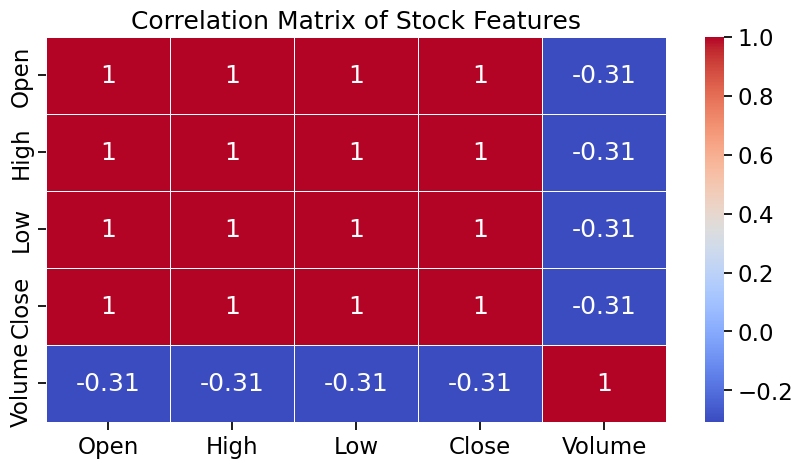

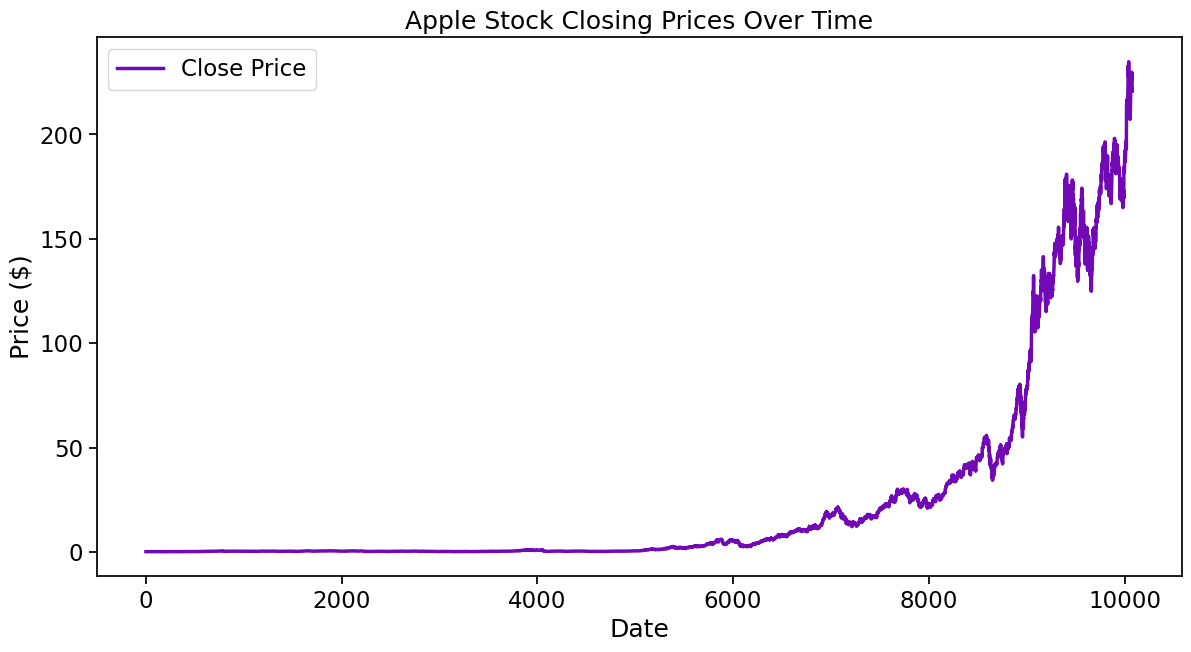

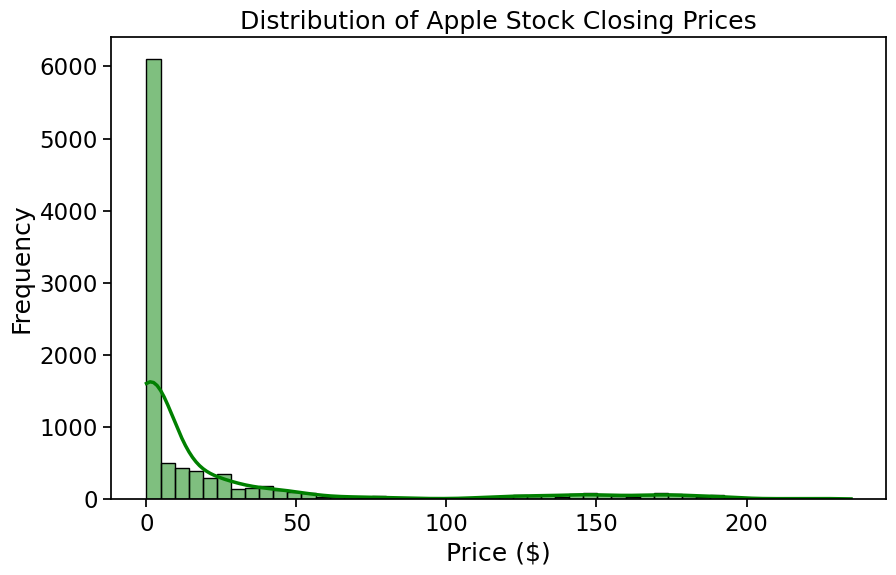

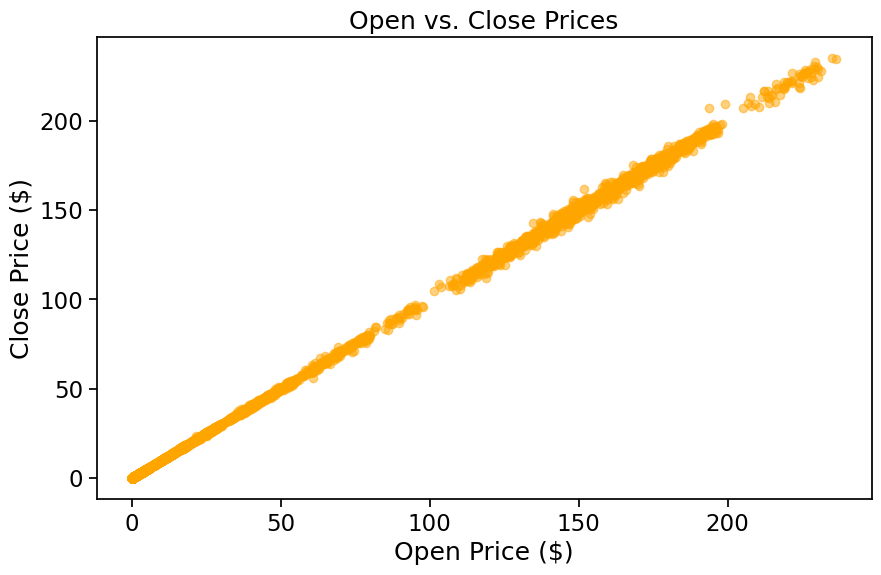

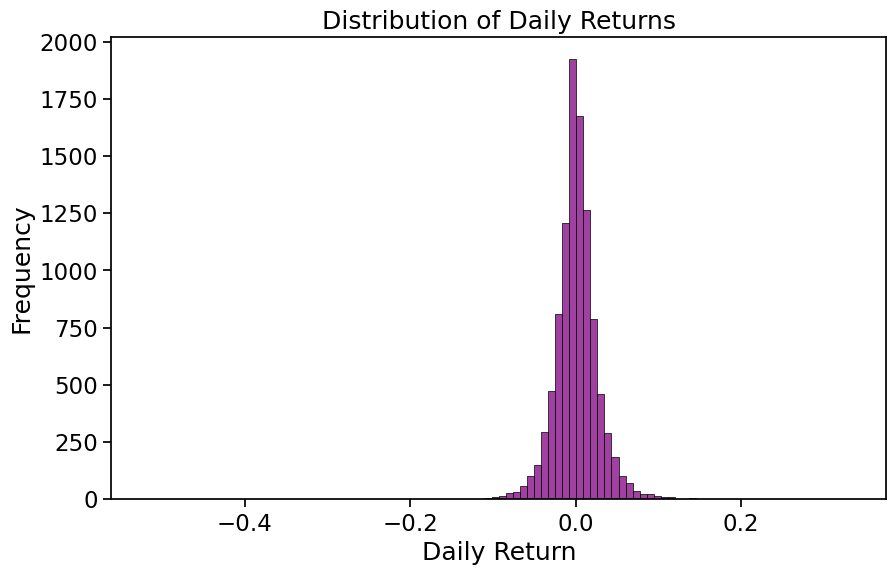

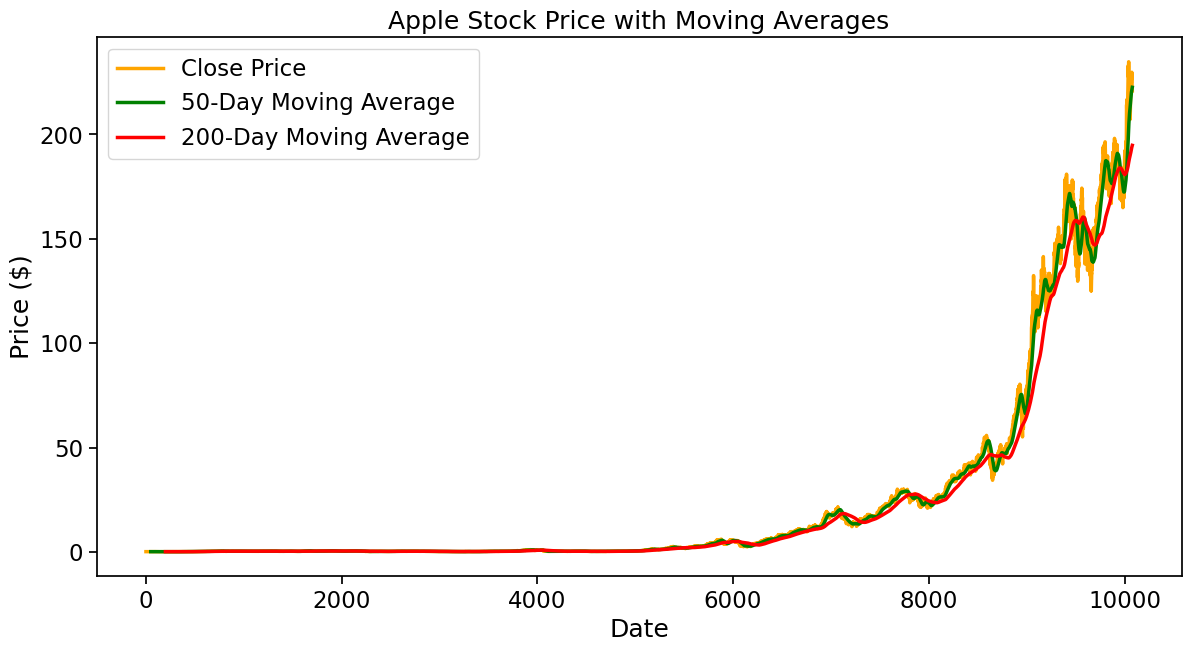

In [20]:
# Customized color palette for the graphs
plt.figure(figsize=(10, 5))
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Features')
plt.show()

# Plot the closing price over time (blue line)
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title('Apple Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Plot the distribution of the closing prices (green histogram with mako palette)
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], bins=50, kde=True, color='green')
plt.title('Distribution of Apple Stock Closing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between Open and Close prices (orange scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(data['Open'], data['Close'], alpha=0.5, color='orange')
plt.title('Open vs. Close Prices')
plt.xlabel('Open Price ($)')
plt.ylabel('Close Price ($)')
plt.show()

# Visualize daily returns
df['Daily Return'] = df['Close'].pct_change()
plt.figure(figsize=(10, 6))
sns.histplot(df['Daily Return'].dropna(), bins=100, color='purple')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

# Plot the moving averages (red for close, green for 50-day MA, blue for 200-day MA)
plt.figure(figsize=(14, 7))
data['Close'].plot(label='Close Price', color='orange')
data['MA50'] = data['Close'].rolling(50).mean()
data['MA200'] = data['Close'].rolling(200).mean()
data['MA50'].plot(label='50-Day Moving Average',color='green')
data['MA200'].plot(label='200-Day Moving Average',color='red')
plt.title('Apple Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [22]:
close_price = data['Close'].values

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Convert the scaled data back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

In [26]:
# Creating sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
       # Create a sequence of data from day 'i' to 'i + seq_length - 1'
        X.append(data.iloc[i:i + seq_length].values)

        # The target value is the stock price for the day immediately after the sequence
        y.append(data.iloc[i + seq_length]['Close'])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 25

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

In [28]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.90) 
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [30]:
print(y_test.shape)

(1006,)

In [32]:
print(X_train.shape)

(9049, 25, 5)

In [34]:
# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(LSTM(units=150, return_sequences=True, input_shape=(60, 5)))
model.add(Dropout(0.3))

# Second LSTM layer with Dropout regularization
model.add(LSTM(units=150, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer without return_sequences
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected Dense layer
model.add(Dense(units=25, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model with Adam optimizer and mean squared error loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Set up early stopping and model checkpoint with .keras format
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Display the model summary
model.summary()

# Fit the model to the training data
# Assume X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, model_checkpoint])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 150)        │        93,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 150)        │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,701 (1.20 MB)

 Trainable params: 315,701 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 9.8380e-05 - val_loss: 6.9578e-04
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 2.8593e-05 - val_loss: 2.9073e-04
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 2.5391e-05 - val_loss: 0.0015
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 2.2200e-05 - val_loss: 9.7203e-04
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 1.9765e-05 - val_loss: 7.7198e-04
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 1.9902e-05 - val_loss: 0.0017
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 2.0379e-05 - val_loss: 0.0014
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 1.8660e-05 - val_loss: 0.0021
Epoch 9/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 1.6617e-05 - val_loss: 0.0023
Epoch 10/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 1.5682e-05 - val_loss: 0.0018
Epoch 11/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 1.9128e-05

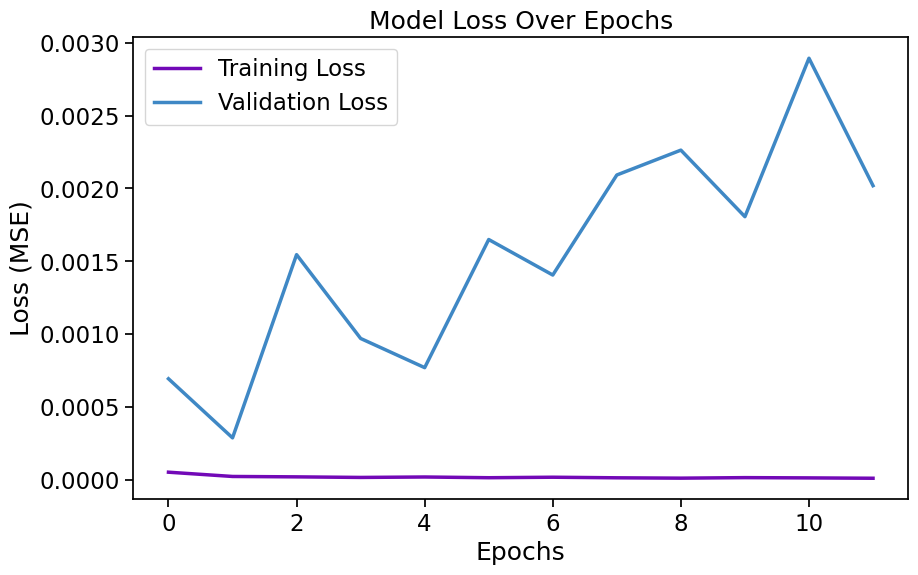

Final Training Loss (MSE): 0.0000

Final Validation Loss (MSE): 0.0020

Final Training RMSE: 0.0037

Final Validation RMSE: 0.0449

Test Loss (MSE): 0.0313

Test RMSE: 0.1769

In [36]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Print the final training and validation loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print(f'Final Training Loss (MSE): {train_loss:.4f}')
print(f'Final Validation Loss (MSE): {val_loss:.4f}')

# Calculate RMSE on the training and validation sets
train_rmse = np.sqrt(train_loss)
val_rmse = np.sqrt(val_loss)
print(f'Final Training RMSE: {train_rmse:.4f}')
print(f'Final Validation RMSE: {val_rmse:.4f}')

# If you have test data, evaluate the model on the test set
# Assume X_test and y_test are already defined and preprocessed
test_loss = model.evaluate(X_test, y_test, verbose=0)
test_rmse = np.sqrt(test_loss)
print(f'Test Loss (MSE): {test_loss:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


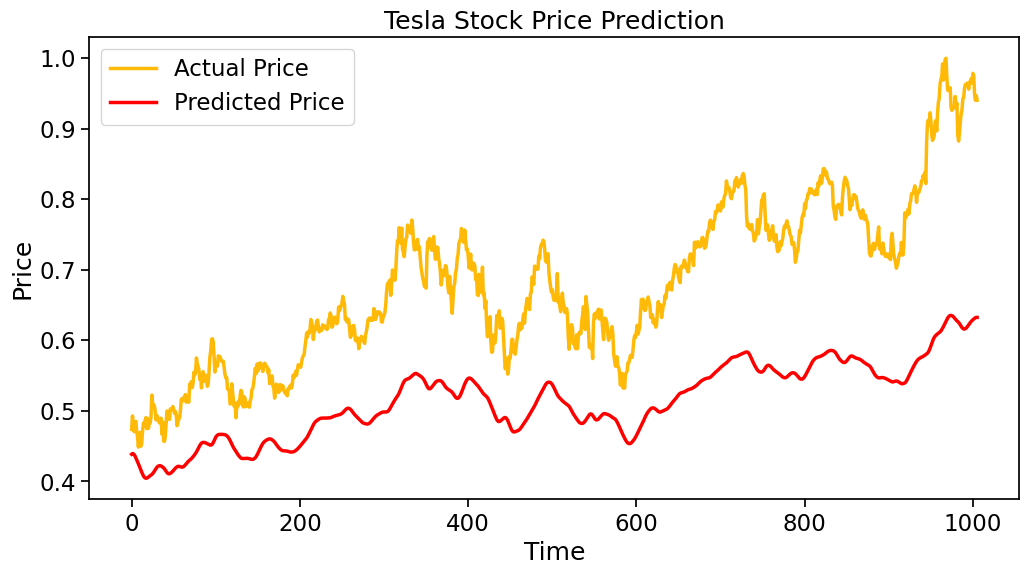

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color= palette[4])
plt.plot(model.predict(X_test), label='Predicted Price', color='red')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()